In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

from numpy.random import seed



Using TensorFlow backend.


# Pipeline

### Data Loader

Python provides a lot of packages to load files in different formats. We provide a simple data loader to help you load .csv files.

In [2]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["id"], df["text"], df["label"]

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["label"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

### Feature Extractor


The **feature extractor** is one of the most important parts in a pipeline.
In this tutorial, we introduce four different functions to extract features.


In [3]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [4]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

### Classifier: Convolutional Neural Network

In this tutorial, we will try to use the convolutional neural network. 

![CNN for Text](cnn_for_text.png)

The CNN consists of three parts: (1) the word representation part, (2) the conv-pool part, and (3) the fully connected part. The word representation part is the word embedding layer; the conv-pool part includes multiple convolutional layers with different kernel sizes, maxpooling layers to aggregate extracted features; the fully connected part utilizes a multi-layer perceptron to make predictions.

In [5]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param kernel_sizes: the kernel sizes of convolutional layers, type: list
    :param num_filters: the number of filters for each kernel, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param padding: the padding method in convolutional layers, type: str
    :param strides: the strides in convolutional layers, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a CNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # convolutional layers document: https://keras.io/layers/convolutional
    # pooling layers document: https://keras.io/layers/pooling/
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    input_length=input_length,
                    embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters,
                      kernel_size=(kernel_size,),
                      padding=padding,
                      strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add skip connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

### Try CNN for Text

As Tutorial 2 and Tutorial 3, we also do the feature selection. However, the convolution with a filter can extract the n-gram-level features. We only select the stemmed features whose frequencies are no less than 3.

In [6]:
train_file = "data/train.csv"
test_file = "data/test.csv"
ans_file = "data/ans.csv"
min_freq = 3

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, _ = load_data(test_file)
test_labels = load_labels(ans_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
test_feats = [filter_stopwords(tokens) for tokens in test_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 3862


We then need to determine the maximum sequence length.

Text(0, 0.5, 'Cumulative Numbers')

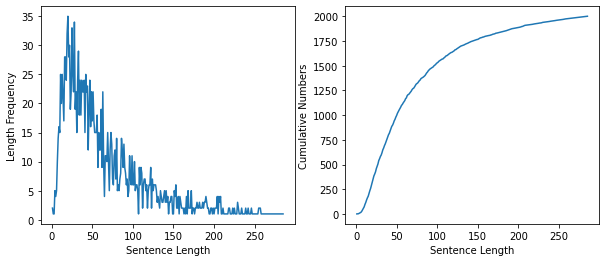

In [7]:
plt.figure(figsize=(10,4))
len_cnt = Counter([len(feats) for feats in train_feats])
len_key = sorted(len_cnt)
plt.subplot(1,2,1)
plt.plot(range(1, len(len_key)+1),
         [len_cnt[l] for l in len_key])
plt.xlabel("Sentence Length")
plt.ylabel("Length Frequency")

plt.subplot(1,2,2)
plt.plot(range(1, len(len_key)+1),
         np.cumsum([len_cnt[l] for l in len_key]))
plt.xlabel("Sentence Length")
plt.ylabel("Cumulative Numbers")

We can find that half of sentences are less than 50 words and most are less than 100 words. We can set the *max_len* as 100.

In [8]:
max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

Let's try a CNN whose *embedding_size* is 100, *kernel_sizes* are 1,2,3,4, *num_filters* is 100, *hidden_size* is 100, *num_mlp_layers* is 3, and *activation* is ReLU.

In [9]:
os.makedirs("models", exist_ok=True)

seed(0)
tf.random.set_random_seed(0)

model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu")
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "cnn1_weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)


cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer])
model = keras.models.load_model(os.path.join("models", "cnn1_weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


400/400 [==============================] - 0s 53us/step
training loss: 0.17525340262800454 training accuracy 0.9624999761581421
test loss: 1.2695884704589844 test accuracy 0.5375000238418579


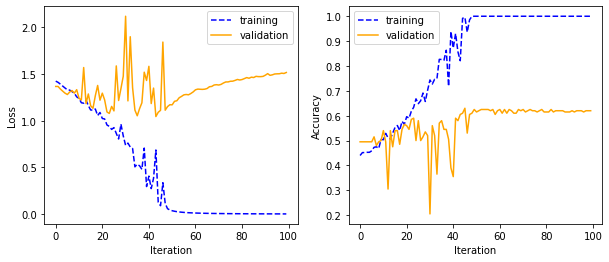

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(cnn_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(cnn_history.history["val_loss"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(cnn_history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(cnn_history.history["val_accuracy"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The training process is very unstable. What's worse, the model is overfitted. We can try all stratigies in previous tutorials to avoid the instability and over-training.

In [11]:
seed(0)
tf.random.set_random_seed(0)

model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu",
                  dropout_rate=0.3, l2_reg=0.05, batch_norm=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "cnn2_weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)


history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer])
model = keras.models.load_model(os.path.join("models", "cnn2_weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

400/400 [==============================] - 0s 90us/step
training loss: 0.5683410346508027 training accuracy 0.8960000276565552
test loss: 1.5249425172805786 test accuracy 0.5625


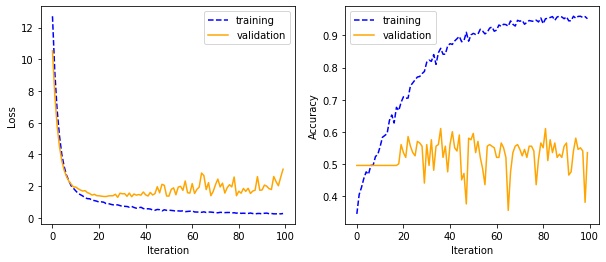

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


After adding the dropout, the l2 regularizer, and the batch normalization, the performance improves, the curves becomes smoother and it takes less iterations for the model to converge during training.